## LSTM을 이용한 네이버 영화 리뷰 분류

### 0. 자연어 처리 (Natural Language Processing, NLP)

* 자연어: 일상 생활에서 사용하는 언어
* 자연어 처리: 자연어의 의미를 분석하여 컴퓨터가 처리할 수 있도록 하는 일
    - Ex. 음석 인식, 내용 요약, 번역, 감성 분석, 텍스트 분류(스팸 메일 분류 등)

### 1. 네이버 영화 리뷰 데이터 이해 및 전처리

In [2]:
#!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from collections import Counter


In [ ]:
## 토큰화 및 vocabulary 생성 완료 데이터 로드
with open("Data/ratings/ratings.pkl", "rb") as f:
    data = pickle.load(f)

test_data = data['test_data']
train_data = data['train_data']
X_test = data['X_test']
X_train = data['X_train']
vocab = data['vocab']

#### 1) 데이터 로드

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="./Data/ratings/ratings_train.txt")  # train 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="./Data/ratings/ratings_test.txt")    # test 데이터 다운로드

('./Data/ratings/ratings_test.txt', <http.client.HTTPMessage at 0x288c2138f70>)

In [6]:
# pandas를 이용해 데이터 로드
train_data = pd.read_table('./Data/ratings/ratings_train.txt')
test_data = pd.read_table('./Data/ratings/ratings_test.txt')

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [8]:
train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


#### 2) 데이터 정제하기

In [10]:
# 결측치 확인
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [11]:
train_data = train_data.dropna(axis=0) # Null 값이 존재하는 행 제거

In [12]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [13]:
# document 열의 중복 제거
train_data = train_data.drop_duplicates(subset=['document'])

In [14]:
train_data.shape

(146182, 3)

In [15]:
print((train_data.label == 0).sum())
print((train_data.label == 1).sum())

73342
72840


In [16]:
# 한글과 공백을 제외하고 모두 제거
# []: 문자 클래스
# ^: not
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [17]:
# ^: 문자열의 시작
# +: 1개 이상 연속된 문자
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data = train_data.replace({'document': ''}, np.nan)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [18]:
train_data = train_data.dropna(axis=0)

In [19]:
## test 데이터 전처리
test_data.drop_duplicates(subset = ['document']) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 한글만 남기기
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data = test_data.replace({'document': ''}, np.nan) # 공백은 Null 값으로 변경
test_data = test_data.dropna(axis=0) # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49575


#### 3) 토큰화(Tokenization)

* 토큰화: 자연어 데이터를 토큰(token)이라 불리는 단위로 나누는 작업
* 예시
    - 입력: Time is an illusion. Lunchtime double so!
    - 출력 : "Time", "is", "an", "illustion", "Lunchtime", "double", "so", "!"
* 영어에서는 단어 단위, 한국어에서는 형태소 단위를 많이 사용함

**불용어 제거**
* 불용어(Stopwords): 조사, 접미사 같이 문장에서는 자주 등장하지만 실제 의미 분석을 하는데는 거의 기여하는 바가 토큰들

In [20]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [21]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [22]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [02:58<00:00, 816.04it/s]


In [23]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [24]:
print(X_train[:5])


[['아', '더빙', '진짜', '짜증나네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'], ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스런', '연기', '돋보였던', '영화', '스파이더맨', '에서', '늙어', '보이기만', '했던', '커스틴', '던스트', '너무나도', '이뻐', '보였다']]


In [25]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 49575/49575 [01:02<00:00, 791.64it/s]


#### 4) 단어 집합(Vocabulary) 만들기

In [29]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 100000


In [30]:
print('훈련 데이터에서의 단어 \'영화\'의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 \'공감\'의 등장 횟수 :', word_counts['공감'])


훈련 데이터에서의 단어 '영화'의 등장 횟수 : 50367
훈련 데이터에서의 단어 '공감'의 등장 횟수 : 1003


In [31]:
word_counts

Counter({'영화': 50367,
         '너무': 11124,
         '정말': 9720,
         '적': 8747,
         '만': 8659,
         '진짜': 8312,
         '으로': 7933,
         '로': 7834,
         '점': 7547,
         '에서': 6981,
         '연기': 6326,
         '것': 6286,
         '평점': 6266,
         '내': 5919,
         '최고': 5785,
         '그': 5670,
         '나': 5577,
         '잘': 5576,
         '안': 5495,
         '이런': 5420,
         '스토리': 5332,
         '생각': 5313,
         '못': 5295,
         '왜': 5120,
         '드라마': 5044,
         '이다': 4920,
         '감동': 4844,
         '사람': 4836,
         '보고': 4717,
         '하는': 4688,
         '하고': 4666,
         '말': 4527,
         '더': 4353,
         '배우': 4287,
         '때': 4279,
         'ㅋㅋ': 4276,
         '아': 4138,
         '감독': 4114,
         '거': 4081,
         '그냥': 4062,
         '본': 4030,
         '요': 4029,
         '재미': 3879,
         '시간': 3866,
         '내용': 3813,
         '까지': 3785,
         '뭐': 3778,
         '중': 3728,
         

In [32]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])


등장 빈도수 상위 10개 단어
['영화', '너무', '정말', '적', '만', '진짜', '으로', '로', '점', '에서']


In [33]:
## 빈도수가 낮은 단어들을 배제
## 등장 빈도수가 3회 미만인 단어들 확인

threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 100000
등장 빈도가 2번 이하인 희귀 단어의 수: 67691
단어 집합에서 희귀 단어의 비율: 67.691
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.079264450054528


In [34]:
# 전체 단어 개수 중 빈도수 3 미만인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))


단어 집합의 크기 : 32309


In [35]:
word_to_index = {}
word_to_index['<PAD>'] = 0 # 패딩 토큰: 문장 길이를 맞추기 위해 사용
word_to_index['<UNK>'] = 1 # 모르는 단어에 대응하기 위함

In [ ]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2


In [37]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)


패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 32311


In [38]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])


단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


#### 5) 정수 인코딩

In [38]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data


In [39]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [40]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[38, 414, 7, 6595, 621]
[902, 416, 30, 564, 2, 176, 1518, 12, 936, 6033, 25781]


In [41]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [42]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['아', '더빙', '진짜', '짜증나네요', '목소리']
복원된 첫번째 샘플 : ['아', '더빙', '진짜', '짜증나네요', '목소리']


#### 6) 패딩(Padding)

* 패딩: 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.935835975597174


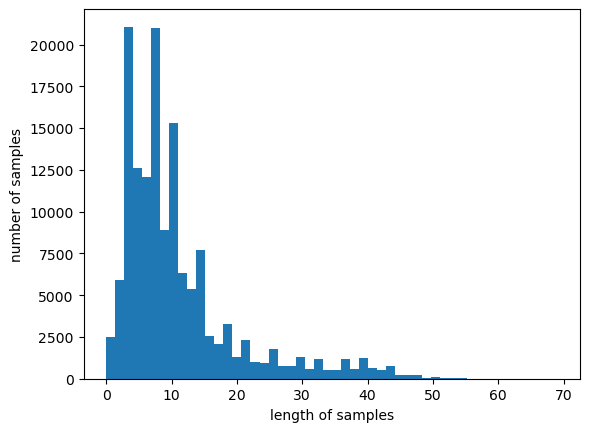

In [43]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [44]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [45]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.10356757202891


In [47]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (145393, 30)
테스트 데이터의 크기 : (49575, 30)


In [48]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [  38  414    7 6595  621    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
